# Analysing top N topic labels for top N users

In [2]:
import os
from os.path import join
import eland as ed
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from collections import Counter

project_dir = join(os.getcwd(), os.pardir)
models_dir = join(project_dir, 'models')

pd.set_option('display.max_colwidth', -1)

%config InlineBackend.figure_format = 'svg'

## List of Topics

In [3]:
TERMS = ['sympathy', 'criticism', 'hope', 'job', 'relief measures', 'compensation',
        'evacuation', 'ecosystem', 'government', 'corruption', 'news updates', 
        'volunteers', 'donation', 'cellular network', 'housing', 'farm', 'utilities', 
        'water supply', 'power supply', 'food supply', 'medical assistance', 'coronavirus', 
        'petition', 'poverty']

## Importing data from Elasticsearch
### We're using elasticsearch database for storing the tweets. The following cell retrieves the tweets from the ES instance running locally

In [4]:
ed_df = ed.DataFrame('localhost', 'twitter')

# defining the full-text query we need: Retrieving records for full_text_processed with the condition is_retweet=False and is_quote_status=False

query_unique = {
    "bool": {
        "must": {
            "term":{"is_retweet":"false"},
        },
        "filter": {
            "term":{"is_quote_status":"false"}
        },
    }
}

# using full-text search capabilities with Eland:
df_ed = ed_df.es_query(query_unique)
df_ed = df_ed.to_pandas()

In [5]:
columns = ['user_id', 'name', 'description', 'verified', 'full_text_trans', 'full_text_processed', 'pov', 'topics', 'retweet_count', 'sentiment', 'location', 'followers_count']
df_tweets = df_ed[columns]
df_tweets['length'] = df_tweets['full_text_processed'].apply(lambda x: len([w for w in x.split()]))
df_tweets = df_tweets[df_tweets['topics'].notna() & df_tweets['full_text_trans'].notna()]

In [6]:
df_tweets.head()

,user_id,name,description,verified,full_text_trans,full_text_processed,pov,topics,retweet_count,sentiment,location,followers_count,length
1263793772833505280,1195928051953098752,C Brihaspati,"I do not believe in summer.\nAlso, any hurt caused to idiots, people of faith and bigots is intentional and heartfelt. So, there you are. Happy?",False,"#Covid19 #MigrantLabourers #Amphan and now the #planecrash near Karachi. This Eid turning out to be a perfect storm of tragedies. Also shows how nothing matters and people's deaths are mere statistics, one set of numbers replaces another. Human race to become more psychopathic.",covid19 migrantlabourers amphan planecrash near karachi eid turning perfect storm tragedy also show nothing matter people death mere statistic one set number replaces another human race become psychopathic,None,[coronavirus],0,0.3964,None,15,28
1263793968963149824,984380724852637696,Udit Gupta ✪,http://news.asksmarty.in,False,"22 parties call upon Centre, seek declaration of cyclone Amphan as natural calamity | India News \nhttps://t.co/LykdBolAal",22 party call upon centre seek declaration cyclone amphan natural calamity india news,None,"[petition, news updates]",0,0.6369,"Jaora, India",40,13
1263794044691415040,1039879135194009600,"JN Raju,irts rtd,tirupati,BJP/RSS/MNI",None,False,@narendramodi Sir\nIt is nice aspect of u visted Amphan cyclone affected states of odissa/W Bengal and expressed problems of people.\nUr moral support to them will remembered ever.\n Praying God to be with people affected for thier up coming early.the people will recognize ur visit and help.\n🙏,narendramodi sir nice aspect u visted amphan cyclone affected state odissaw bengal expressed problem people ur moral support remembered ever praying god people affected thier coming earlythe people recognize ur visit help 🙏,third,"[petition, relief measures, hope, sympathy]",0,0.7845,Tirupathi,27,33
1263793570474934272,171997301,PatralekhaChatterjee পত্রলেখা চ্যাটার্জী,"journalist.Bylines:@TheLancet, @bmj_latest @TheAtlIdeas,@MediaPart @NewStatesman,@AsianAge,@DeccanChronicle,@AmarUjala,@theHindu, @businessline,@GaonConnection",False,"The famous South Asian out-of-the-box thinking kicking in as one tries to talk to people in Amphan-ravaged areas with zero or poor connectivity . No power, no internet, no phone connection but still one tries and sometimes succeed.",famous south asian outofthebox thinking kicking one try talk people amphanravaged area zero poor connectivity power internet phone connection still one try sometimes succeed,None,[hope],1,0.0258,None,5349,24
1263793365843431424,18692541,enwikipedia 🌟,Unofficial tweets a few times daily about featured content from English Wikipedia and related projects. Follow links for image credits. A bot by @johndburger,False,"News: Cyclone Amphan (satellite image shown) impacts eastern India and Bangladesh, killing over one hundred people and forcing the evacuation of more than four million others https://t.co/I7sFGNx738",news cyclone amphan satellite image shown impact eastern india bangladesh killing one hundred people forcing evacuation four million others,None,"[evacuation, news updates]",0,-0.6597,None,739,19


## Top N most retweeted users

In [8]:
N = 50
df_tweets.groupby(['user_id', 'name', 'description', 'verified'])['retweet_count'].agg({'sum'}).nlargest(N, 'sum')

,,,,sum
user_id,name,description,verified,
18839785,Narendra Modi,Prime Minister of India,True,132901
3171712086,Rahul Gandhi,This is the official account of Rahul Gandhi | Member of the Indian National Congress| Member of Parliament,True,48879
939091,Joe Biden,"Senator, Vice President, 2020 candidate for President of the United States, husband to @DrBiden, proud father & grandfather. Loves ice cream, aviators & @Amtrak",True,42995
471741741,PMO India,Office of the Prime Minister of India,True,32204
75246346,Sudhir Chaudhary,"Editor In Chief, Zee News, Zee Business, WION. Hosts India's No.1 News Show DNA every night at 9. Recipient of Ramnath Goenka Award for Hindi Journalism",True,28343
783214,Twitter,bye,True,27047
52544275,Ivanka Trump,"Wife, mother, sister, daughter. Advisor to POTUS on job creation + economic empowerment, workforce development & entrepreneurship. Personal Pg. Views are my own",True,24152
122453931,Imran Khan,Prime Minister of Pakistan,True,23968
2455740283,MrBeast,I want to make the world a better place before I die.,True,18841


## Aggregating the columns to create a popularity measure

In [9]:
df_users = df_tweets.groupby('user_id').agg({
            'name': lambda x: x.iloc[0],
            'followers_count': lambda x: x.iloc[0],
            'retweet_count': 'sum',
            'sentiment': 'median',
            'verified': lambda x: x.iloc[0],
            'description': lambda x: x.iloc[0],
        })

## Log Normalising the followers and retweet count

In [10]:
df_users['followers_count'] = df_users['followers_count'].apply(lambda x: np.log(x + 1))
df_users['retweet_count'] = df_users['retweet_count'].apply(lambda x: np.log(x + 1))
df_users['verified'] = df_users['verified'].apply(lambda x: int(x) if x==True else 0)

In [11]:
df_users.nlargest(10, ['retweet_count', 'followers_count'])

,name,followers_count,retweet_count,sentiment,verified,description
user_id,,,,,,
18839785,Narendra Modi,17.920670,11.797367,0.64860,1,Prime Minister of India
3171712086,Rahul Gandhi,16.555496,10.797124,0.10600,1,This is the official account of Rahul Gandhi | Member of the Indian National Congress| Member of Parliament
939091,Joe Biden,15.859332,10.668862,0.00000,1,"Senator, Vice President, 2020 candidate for President of the United States, husband to @DrBiden, proud father & grandfather. Loves ice cream, aviators & @Amtrak"
471741741,PMO India,17.441991,10.379877,0.42150,1,Office of the Prime Minister of India
75246346,Sudhir Chaudhary,15.541488,10.252171,-0.39665,1,"Editor In Chief, Zee News, Zee Business, WION. Hosts India's No.1 News Show DNA every night at 9. Recipient of Ramnath Goenka Award for Hindi Journalism"
783214,Twitter,17.881097,10.205368,0.00000,1,bye
52544275,Ivanka Trump,16.038361,10.092164,0.88850,1,"Wife, mother, sister, daughter. Advisor to POTUS on job creation + economic empowerment, workforce development & entrepreneurship. Personal Pg. Views are my own"
122453931,Imran Khan,16.322051,10.084517,-0.12800,1,Prime Minister of Pakistan
101311381,Shah Rukh Khan,17.525650,10.027076,0.64860,1,None


## Popularity Measure = Sum of Log Normalised Scores

In [12]:
df_users['popularity'] = df_users['followers_count']+df_users['retweet_count']+df_users['verified']

In [13]:
N = 50
df_users.nlargest(N, 'popularity')[['name', 'description', 'sentiment', 'popularity']]

,name,description,sentiment,popularity
user_id,,,,
18839785,Narendra Modi,Prime Minister of India,0.64860,30.718037
783214,Twitter,bye,0.00000,29.086465
471741741,PMO India,Office of the Prime Minister of India,0.42150,28.821868
101311381,Shah Rukh Khan,None,0.64860,28.552726
759251,CNN,It’s our job to #GoThere & tell the most difficult stories. Join us! For more breaking news updates follow @CNNBRK & download our app http://cnn.com/apps,0.02580,28.378315
3171712086,Rahul Gandhi,This is the official account of Rahul Gandhi | Member of the Indian National Congress| Member of Parliament,0.10600,28.352619
939091,Joe Biden,"Senator, Vice President, 2020 candidate for President of the United States, husband to @DrBiden, proud father & grandfather. Loves ice cream, aviators & @Amtrak",0.00000,27.528195
807095,The New York Times,News tips? Share them here: http://nyti.ms/2FVHq9v,0.00000,27.520113
1447949844,Amit Shah,"Union Home Minister, Government of India | MP, Gandhinagar Lok Sabha. http://www.instagram.com/amitshahofficial",0.09165,27.479747


## Extracting Top N topics for Top N users

In [34]:
N = 5
topic_users = []
for id, row in df_users.iterrows():
    topic_list = df_tweets[df_tweets['user_id']==id]['topics']
    topic_counter = [item for x in topic_list for item in x]
    top_n = sorted(Counter(topic_counter), key = Counter(topic_counter).get, reverse = True)[:N]
    topic_users.append(top_n)

In [36]:
df_users['topics'] = topic_users

In [37]:
N = 50
top_users = df_users.nlargest(N, 'popularity')

In [43]:
top_users[['name', 'description', 'popularity', 'topics']].head(50)

,name,description,popularity,topics
user_id,,,,
18839785,Narendra Modi,Prime Minister of India,30.718037,"[sympathy, government, relief measures, hope, job]"
783214,Twitter,bye,29.086465,[hope]
471741741,PMO India,Office of the Prime Minister of India,28.821868,"[relief measures, government, sympathy, hope, evacuation]"
101311381,Shah Rukh Khan,None,28.552726,"[housing, relief measures, hope, sympathy]"
759251,CNN,It’s our job to #GoThere & tell the most difficult stories. Join us! For more breaking news updates follow @CNNBRK & download our app http://cnn.com/apps,28.378315,"[relief measures, coronavirus, evacuation, petition, government]"
3171712086,Rahul Gandhi,This is the official account of Rahul Gandhi | Member of the Indian National Congress| Member of Parliament,28.352619,"[sympathy, hope, evacuation, relief measures, petition]"
939091,Joe Biden,"Senator, Vice President, 2020 candidate for President of the United States, husband to @DrBiden, proud father & grandfather. Loves ice cream, aviators & @Amtrak",27.528195,[job]
807095,The New York Times,News tips? Share them here: http://nyti.ms/2FVHq9v,27.520113,"[evacuation, news updates, ecosystem, relief measures, hope]"
1447949844,Amit Shah,"Union Home Minister, Government of India | MP, Gandhinagar Lok Sabha. http://www.instagram.com/amitshahofficial",27.479747,"[government, sympathy, relief measures, food supply, poverty]"


## Label Distribution based on Popularity buckets

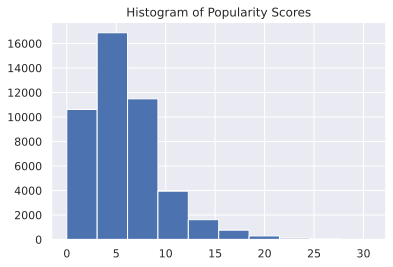

In [47]:
n = plt.hist(df_users['popularity'])
bins = n[1]
plt.title('Histogram of Popularity Scores')
plt.show()

In [48]:
'''Extracting the label distribution for users falling in the specified bin'''
def popularity_topic_dist(value_1, value_2):
    topic_list = df_users[(df_users['popularity']>=value_1) & (df_users['popularity']<value_2)]['topics']
    topic_counter = Counter([item for x in topic_list for item in x])
    sum_val = sum(topic_counter.values())
    for t in topic_counter.keys():
        topic_counter[t] = np.round(topic_counter[t]/sum_val,2)
    return topic_counter

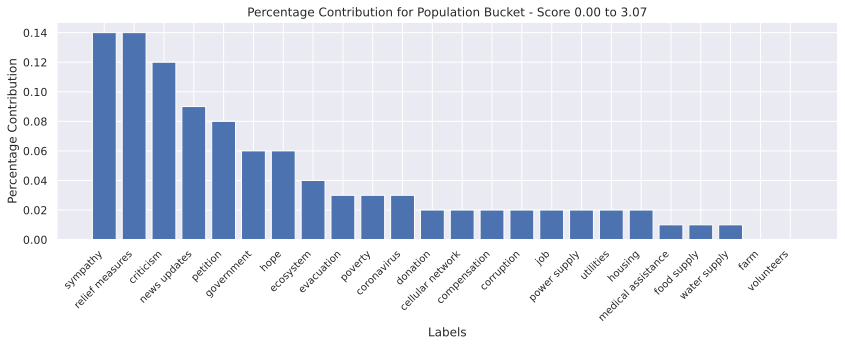

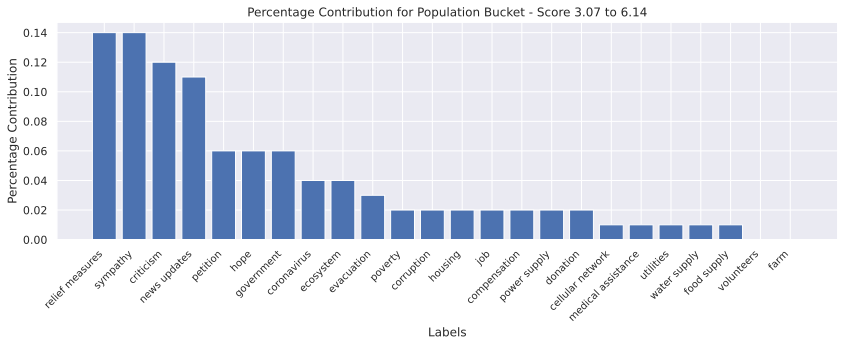

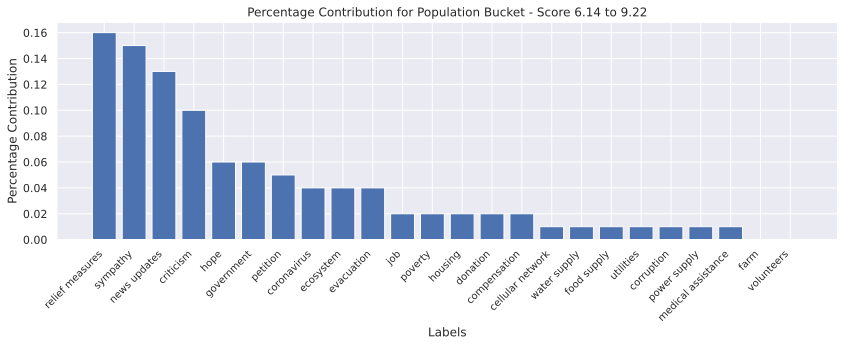

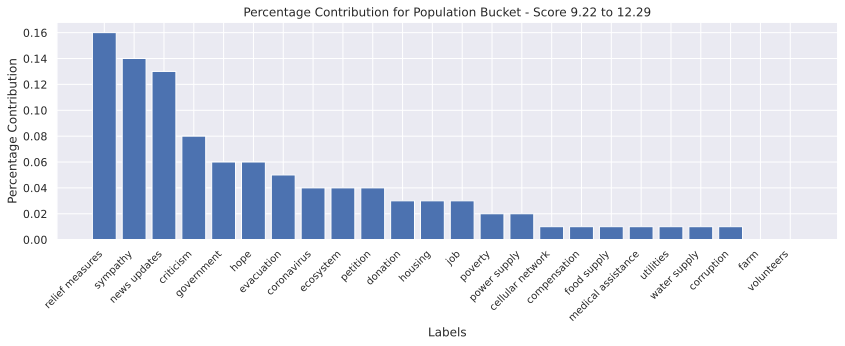

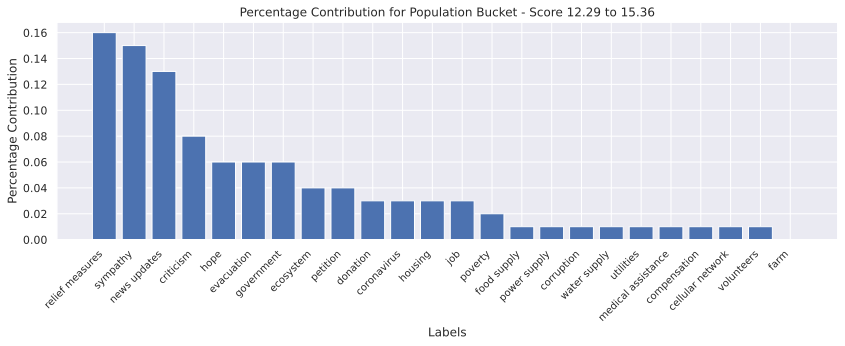

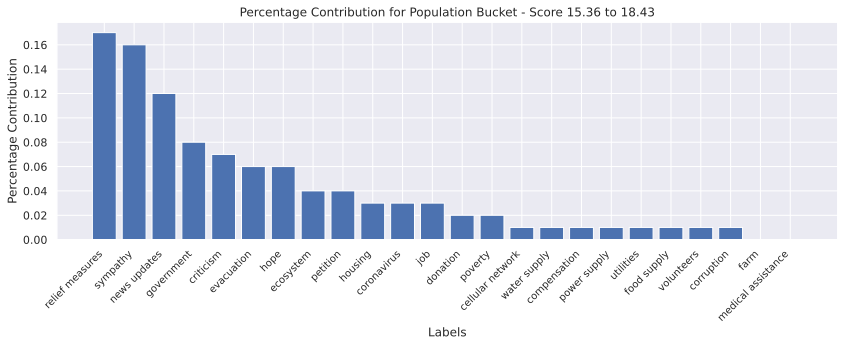

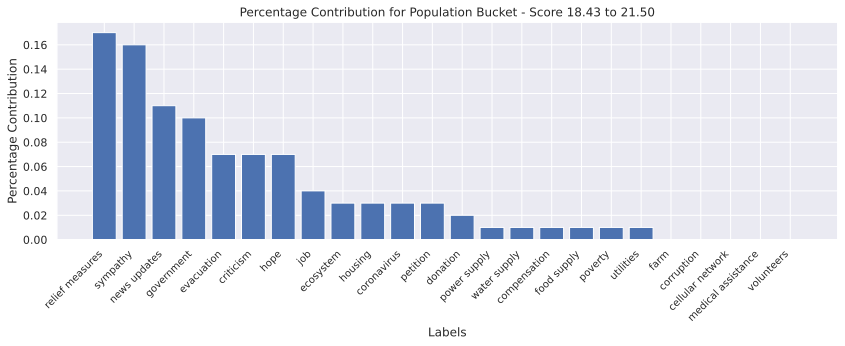

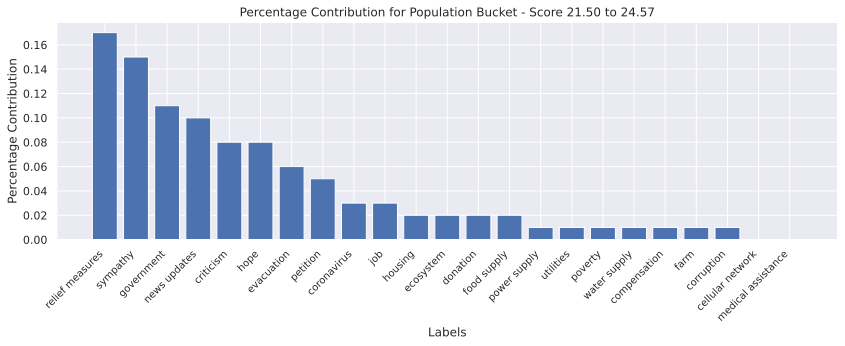

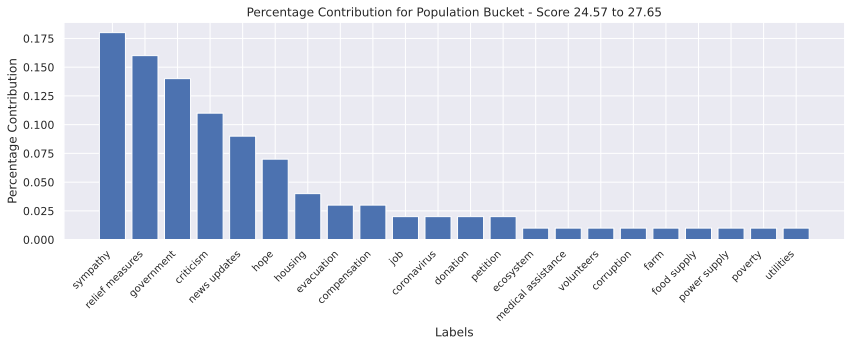

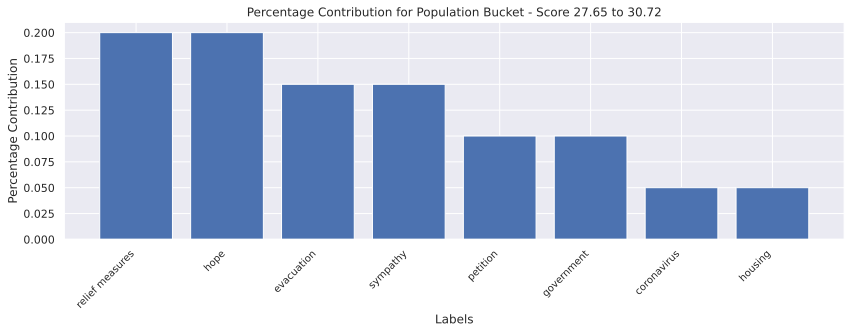

In [49]:
title = 'Percentage Contribution for Population Bucket - Score {bin_1:.2f} to {bin_2:.2f}'
for x in range(len(bins)-1):
    topic_dist = popularity_topic_dist(bins[x], bins[x+1])
    values = [x[1] for x in topic_dist.most_common()]
    keys = [x[0] for x in topic_dist.most_common()]
    plt.figure(figsize=(14,4))
    plt.bar(height=values, x=keys)
    plt.xticks(rotation=45, horizontalalignment='right', fontsize='small')
    plt.xlabel('Labels')
    plt.ylabel('Percentage Contribution')
    plt.title(title.format(bin_1=bins[x], bin_2=bins[x+1]))
    plt.show()